In [815]:
import pandas as pd
from pathlib import Path

streams_features_file = r"/Users/James/Documents/Python/Machine Learning Projects/Spotify_Listening_Analysis/Spotify 2.0/preprocessing/pickles/my_features.pkl"
streams_features_raw = pd.read_pickle(streams_features_file)
streams_features = streams_features_raw.copy()


columns_to_drop = ["type", "id", "uri", "track_href", "analysis_url", "time_signature"]
streams_features.drop(columns_to_drop, inplace=True, axis=1)


def convert_duration(dataframe=streams_features):
    dataframe["duration"] = dataframe["duration_ms"].divide(60000)
    dataframe.drop("duration_ms", axis=1, inplace=True)
    return dataframe


def add_play_count(dataframe=streams_features):
    dataframe["playCount"] = dataframe["minutesTotal"] / dataframe["duration"]
    return dataframe


streams_features = convert_duration(streams_features)
streams_features = add_play_count(streams_features)

streams_features = streams_features[
    (streams_features["artistName"] != "John Mayer")
    & (streams_features["trackName"] != "On The Way Home")
]  # this one song has an incorrect duration and is returning a 30+ play count, definitely something not right


In [816]:
def plot_loss(model_history):
    plt.plot(pd.DataFrame(model_history.history["loss"]), label = "loss")
    plt.plot(pd.DataFrame(model_history.history["val_loss"]), label = "val_loss")
    plt.grid(True)
    #plt.gca().set_ylim(0, 10)
    plt.xlabel("Epoch")
    plt.ylabel("MSE")
    plt.legend()
    plt.show()

In [817]:
#streams_features.info()

In [818]:
import seaborn as sns
import matplotlib.pyplot as plt

<AxesSubplot:xlabel='playCount', ylabel='Count'>

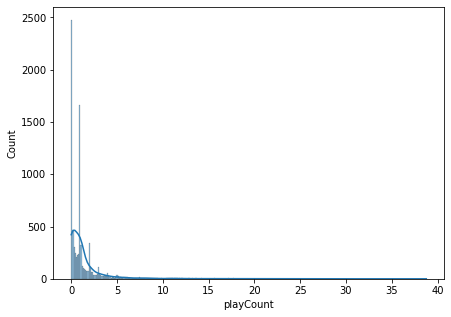

In [819]:
fig, ax = plt.subplots(figsize=(7,5));
sns.histplot(data = streams_features, x = "playCount", stat = "count", kde = True)

<AxesSubplot:xlabel='playCount', ylabel='Count'>

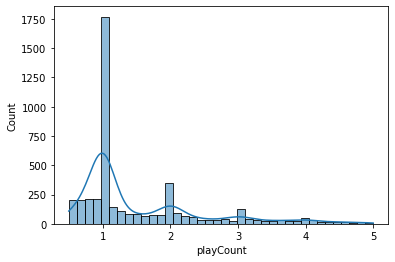

In [844]:
#Removing outliers 
streams_features = streams_features[streams_features["playCount"]<5]
streams_features = streams_features[streams_features["playCount"]>=0.5]
#streams_features.count()
sns.histplot(data = streams_features, x = "playCount", stat = "count", kde = True)

In [845]:
corr_matrix = streams_features.corr()
corr_matrix["playCount"].sort_values(ascending=False)

playCount           1.000000
minutesTotal        0.809257
loudness            0.067667
energy              0.067566
valence             0.040325
mode                0.032735
duration            0.018403
tempo               0.008630
danceability       -0.002038
key                -0.010423
liveness           -0.015522
speechiness        -0.059986
acousticness       -0.060249
instrumentalness   -0.103600
Name: playCount, dtype: float64

<AxesSubplot:>

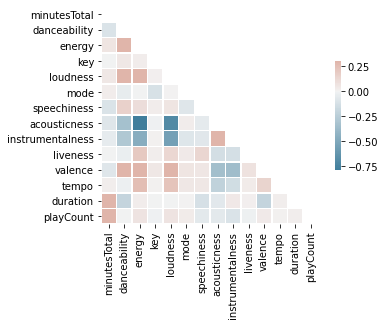

In [846]:
import numpy as np
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [847]:
X = streams_features.drop(["artistName", "trackName", "minutesTotal", "trackId", "playCount"], axis = 1)
y = streams_features["playCount"]

In [848]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
standard_scalar  = StandardScaler()
min_max_scaler = MinMaxScaler()
#X = min_max_scaler.fit_transform(X)
X = standard_scalar.fit_transform(X)

In [849]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test  = train_test_split(X,y, test_size=0.2, random_state=42)

In [850]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train,y_train, test_size=0.1, random_state=42)

In [851]:
X_lengths = {"X_train" : len(X_train), "X_test" : len(X_test), "X_valid" : len(X_valid)}
y_lengths = {"y_train" : len(y_train), "y_test" : len(y_test), "y_valid" : len(y_valid)}

In [852]:
X_lengths, y_lengths

({'X_train': 3231, 'X_test': 898, 'X_valid': 360},
 {'y_train': 3231, 'y_test': 898, 'y_valid': 360})

In [853]:
import tensorflow as tf
from tensorflow import keras

In [854]:
model_params = {
    "optimizer":keras.optimizers.Adam(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=True,
    name='Adam'), 
    "loss": tf.keras.losses.MeanSquaredError(),
    "hidden_activation":"relu",
    "output_activation":"relu",  
    #"loss":keras.losses.Huber(), 
    "initializer" : tf.keras.initializers.HeNormal()
}

In [855]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=3, min_lr=0.00001)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5,min_delta = 0.0001)

In [856]:
model = keras.models.Sequential([
    keras.layers.Dense(50, activation=model_params["hidden_activation"], input_shape=X_train.shape[1:], 
                       kernel_initializer=model_params["initializer"]),
    #keras.layers.Dense(50, activation=model_params["hidden_activation"]),
    #keras.layers.Dense(30, activation=model_params["hidden_activation"]),
    #keras.layers.Dense(25, activation=model_params["hidden_activation"],kernel_initializer=model_params["initializer"]),
    keras.layers.Dense(20, activation=model_params["hidden_activation"],kernel_initializer=model_params["initializer"]),
    keras.layers.Dense(1, activation=model_params["output_activation"]),
])

model.compile(loss=model_params["loss"], 
              optimizer=model_params["optimizer"])

In [857]:
loss_min = {}
val_loss_min = {}
for i in [250]:
    history = model.fit(X_train, 
                    y_train, 
                    epochs=i, 
                    verbose = 1, 
                    validation_data=(X_valid, y_valid),
                    callbacks = [early_stopping],
                    batch_size = 32)
    loss_min[i] = min(history.history["loss"])
    val_loss_min[i] = min(history.history["val_loss"])

Epoch 1/250
101/101 [==============================] - 0s 5ms/step - loss: 1.6397 - val_loss: 0.8485
Epoch 2/250
101/101 [==============================] - 0s 2ms/step - loss: 1.0621 - val_loss: 0.8256
Epoch 3/250
101/101 [==============================] - 0s 3ms/step - loss: 0.9899 - val_loss: 0.8031
Epoch 4/250
101/101 [==============================] - 0s 4ms/step - loss: 0.9581 - val_loss: 0.7719
Epoch 5/250
101/101 [==============================] - 0s 4ms/step - loss: 0.9431 - val_loss: 0.7916
Epoch 6/250
101/101 [==============================] - 0s 4ms/step - loss: 0.9299 - val_loss: 0.7625
Epoch 7/250
101/101 [==============================] - 0s 3ms/step - loss: 0.9173 - val_loss: 0.7537
Epoch 8/250
101/101 [==============================] - 0s 4ms/step - loss: 0.9051 - val_loss: 0.8392
Epoch 9/250
101/101 [==============================] - 0s 2ms/step - loss: 0.8992 - val_loss: 0.7527
Epoch 10/250
101/101 [==============================] - 0s 4ms/step - loss: 0.8925 - val_lo

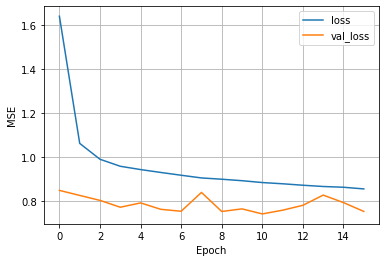

In [858]:
plot_loss(history)

In [859]:
loss_min, val_loss_min

({250: 0.8551895022392273}, {250: 0.7415920495986938})

In [860]:
streams_features["playCount"].mean()


1.528641460369286

In [246]:
#mse_test = model.evaluate(X_test, y_test)